In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [2]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

print(tf.__version__)

# Build a dataflow graph.
c = tf.constant([[1.0, 2.0], [3.0, 4.0]])
d = tf.constant([[1.0, 1.0], [0.0, 1.0]])
e = tf.matmul(c, d)

# Construct a `Session` to execute the graph.
sess = tf.compat.v1.Session()

# Execute the graph and store the value that `e` represents in `result`.
result = sess.run(e)
print(result)

2.9.2
[[1. 3.]
 [3. 7.]]


In [3]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [4]:
labels = ['Abnormal (Pneumonia)','Normal']

In [5]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Chest_XRay_Dataset02/train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        try:
            img = cv2.resize(img,(image_size, image_size))
        except:
            break
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 1575/1575 [00:18<00:00, 86.97it/s] 


In [6]:
X_train.shape

(5840, 224, 224, 3)

In [7]:
X_train, y_train = shuffle(X_train,y_train, random_state=1010)

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.3,random_state=1010)

In [9]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [46]:
import keras
import keras.utils
from keras import utils as np_utils
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
import keras.backend as k
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform

In [11]:
k.clear_session()
def inception_module(x, f1, f2, f3, f4):
		# 1x1 conv
		conv1 = keras.layers.Conv2D(f1, (1,1), strides=(1, 1), padding='same', activation='relu')(x)
		# 3x3 conv
		conv3 = keras.layers.Conv2D(f2, (3,3), strides=(1, 1), padding='same', activation='relu')(x)
		# 5x5 conv
		conv5 = keras.layers.Conv2D(f3, (5,5), strides=(1, 1), padding='same', activation='relu')(x)
		conv7 = keras.layers.Conv2D(f4, (7,7), strides=(1, 1), padding='same', activation='relu')(x)
		x = keras.layers.concatenate([conv1, conv3, conv5, conv7])
		return x

In [12]:
def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1)):
   
    x = keras.layers.Conv2D(filters, (num_row, num_col),strides=strides,padding=padding)(x)
    x = keras.layers.BatchNormalization(axis=3, scale=False)(x)
    x = keras.layers.Activation('relu')(x)
    return x

In [13]:
img_input = keras.Input(shape=(224, 224, 3))  #shape=(None, 299, 299, 3)

In [14]:
#OURmODELv6
#conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1))
x = conv2d_bn(img_input, 64, 7, 7, strides=(2, 2), padding='same') # 149 x 149 x 32
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

x = conv2d_bn(x, 64, 1, 1, padding='same')  # 147 x 147 x 32
x = conv2d_bn(x, 192, 3, 3, padding='same') # 147 x 147 x 64
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

#inception_module(x, f1, f2, f3)
x = inception_module(x, 128, 128, 128, 128)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 192, 192, 192, 192)
x = inception_module(x, 256, 256, 256, 256)
x = inception_module(x, 256, 256, 256, 256)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 512, 512, 512, 512)
x = keras.layers.MaxPooling2D((7, 7), strides=(1, 1))(x)  # 35 x 35 x 192

#x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x) # shape=(None, 2048)
x = Flatten()(x)
x = keras.layers.Dense(1000, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(2, activation='softmax', name='predictions')(x) #shape=(None, 1000) 

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
# Create model.
inputs = img_input
model =  keras.Model(inputs, x, name='CXRay-SPNet')
model.summary()

Model: "CXRay-SPNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  192        ['conv2d[0][0]']                 
 alization)                     )                                                       

In [16]:
model.compile(loss='categorical_crossentropy',optimizer = 'adam', metrics= ['accuracy'])

In [17]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("CXRay-SPNet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [18]:
history = model.fit(X_train,y_train,validation_split=0.2, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Train on 3270 samples, validate on 818 samples
Epoch 1/50
3270/3270 [==============================] - ETA: 0s - loss: 124.1027 - accuracy: 0.7841

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_accuracy improved from -inf to 0.28240, saving model to CXRay-SPNet.h5
3270/3270 [==============================] - 76s 23ms/sample - loss: 124.1027 - accuracy: 0.7841 - val_loss: 2.0529 - val_accuracy: 0.2824 - lr: 0.0010
Epoch 2/50
3270/3270 [==============================] - ETA: 0s - loss: 0.2195 - accuracy: 0.9141
Epoch 2: val_accuracy improved from 0.28240 to 0.83374, saving model to CXRay-SPNet.h5
3270/3270 [==============================] - 54s 16ms/sample - loss: 0.2195 - accuracy: 0.9141 - val_loss: 0.3813 - val_accuracy: 0.8337 - lr: 0.0010
Epoch 3/50
3270/3270 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9413
Epoch 3: val_accuracy improved from 0.83374 to 0.91198, saving model to CXRay-SPNet.h5
3270/3270 [==============================] - 53s 16ms/sample - loss: 0.1523 - accuracy: 0.9413 - val_loss: 0.2274 - val_accuracy: 0.9120 - lr: 0.0010
Epoch 4/50
3270/3270 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.

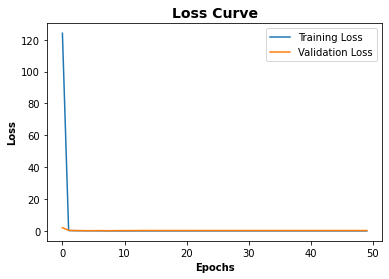

In [19]:
#plot the loss curve
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.ylabel('Loss',fontweight='bold')
plt.title('Loss Curve',fontweight='bold', fontsize=14)
plt.xlabel('Epochs',fontweight='bold')
plt.savefig('CXRay_SPNet_LossCurve',dpi=400)
plt.legend()

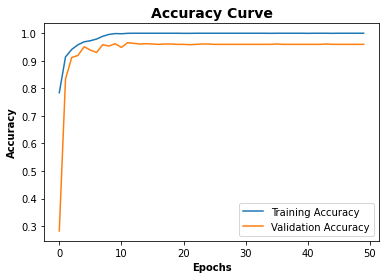

In [20]:
#plot the accuracy curve
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.ylabel('Accuracy',fontweight='bold')
plt.title('Accuracy Curve',fontweight='bold', fontsize=14)
plt.xlabel('Epochs',fontweight='bold')
plt.savefig('CXRay_SPNet_AccCurve',dpi=400)
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


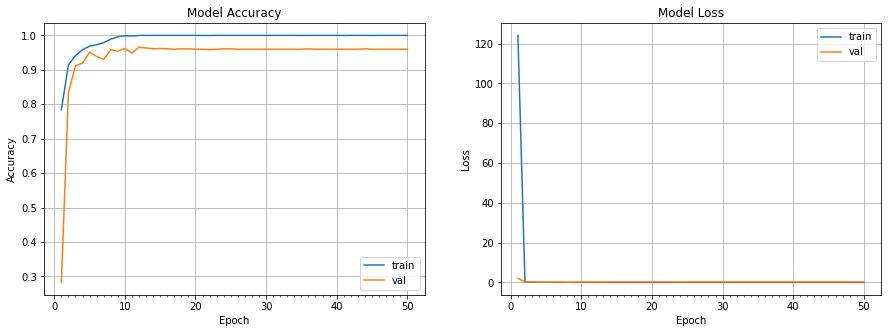

In [21]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[0].grid()
    
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    axs[1].grid()
    plt.show()
    
plot_model_history(history)

In [22]:
# Saving model and weights
from numpy import loadtxt
from keras.models import load_model

# save model and architecture to single file

model.save("CXRay-SPNet.h5")
print("Saved model to disk")

Saved model to disk


In [23]:
# load model
model = load_model('/content/CXRay-SPNet.h5')


In [24]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

Shape of each image : (224, 224, 3)


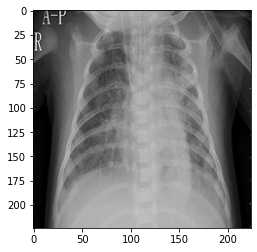

resized_img Dimensions :  (224, 224, 3)


In [25]:
# Query image to explain
import cv2
image = load_img("/content/drive/MyDrive/Chest_XRay_Dataset02/check/Abnormal (Pneumonia))/person1946_bacteria_4874.jpg")
image = np.array(image)
print(f"Shape of each image : {image.shape}")
plt.imshow(image)
plt.show()

query_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
print('resized_img Dimensions : ',query_image.shape)


In [26]:
from keras.activations import softmax, linear

In [27]:
# Saliency map using Backpropagation w.r.t. input
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
def unnormed_output_model(model):
    '''
    unnormed_output_model return a model exactly same as vgg16, except that the output
    layer use a linear activation rather than softmax
    '''
    
    #check if last layer has softmax as activation
    assert model.layers[-1].activation == softmax

    #get the weights from last layer
    weights = model.layers[-1].get_weights()
        
    #create a new layer as last layer, set it weights use 'weights'
    config = model.layers[-1].get_config()
    config['activation'] = None
    config['name'] = 'pred'
    lastlayer_without_softmax = Dense(**config)(model.layers[-2].output)
    
    #build a new model, and set lastlayers weight
    model_without_softmax = Model(inputs=model.input, outputs=[lastlayer_without_softmax])
    model_without_softmax.layers[-1].set_weights(weights)
    
    #check if last layer is linear
    assert model_without_softmax.layers[-1].activation == linear
    
    return model_without_softmax

def backprop_saliency_map(model, img):

    #calculate grads to input image
    variable = model.input
    loss = model.layers[-1].output
    grads = K.gradients (loss, variable)
    func = K.function([variable], [grads, loss])
      
    #use the maximum absolute value among channels per pixel
    w, loss_value = func(img)
    saliency_map = np.max(np.absolute(w[0][0]), axis=2)
    return saliency_map

In [28]:
# Backpropagation saliency map
def backpropagation(model, query_img, visualise=True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, query_img)

    if visualise:
        plt.figure(figsize=(10, 20))
        plt.subplot(121)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(np.squeeze(query_img,0))
        
        plt.subplot(122)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

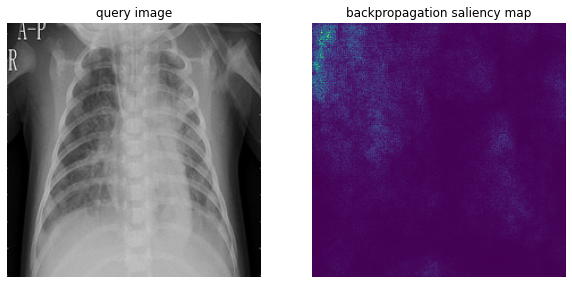

In [29]:
# Backpropagation saliency map
backpropagation(model, np.expand_dims(query_image,0))

In [30]:
# Guided Backpropagation

def build_guided_model():

    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
    return new_model


def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

In [31]:
def guided_backprop_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)

    if visualise:
        plt.figure(figsize=(10, 10))
        plt.subplot(131)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(132)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(133)
        plt.title('Guided backpropagation')
        plt.axis('off')
        plt.imshow(np.squeeze(gb, 0))

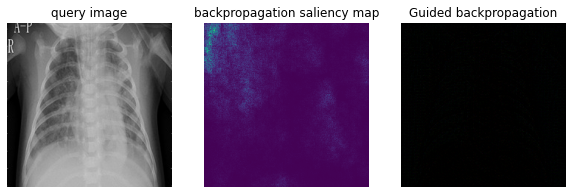

In [32]:
# guided Backpropagation
guided_backprop_saliency_map(model, (query_image), layer_name='conv2d_1')

In [33]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))
    
    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0  
    cam = cv2.resize(cam, (224,224))

    return cam

In [34]:
def gradcam_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0), layer_name='conv2d_1' )
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(141)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(142)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(143)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)


        plt.subplot(144)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(np.squeeze(guided_gradcam,0))
        

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


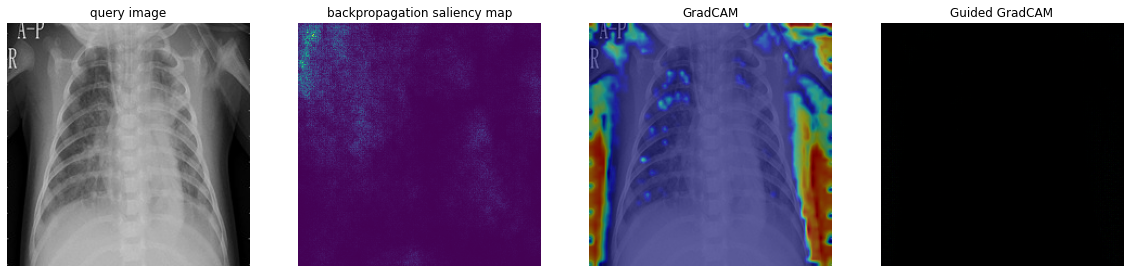

In [35]:
# Visualising GradCAM and GradCAM++
gradcam_saliency_map(model, query_image, 'conv2d_1')

In [36]:
# old
def grad_cam_plus(input_model, img, cls, layer_name, H=224,W=224):

    cls = np.argmax(input_model.predict(img))
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads*grads

    gradient_function = K.function([input_model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)

    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)

    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))

    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)
    # print deep_linearization_weights
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    # Passing through ReLU
    cam = np.maximum(grad_CAM_map, 0)
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = cam / np.max(cam) # scale 0 to 1.0    

    return cam

In [37]:
def GradCamPlusPlus(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads*grads

    gradient_function = K.function([model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img_array])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)
    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))
    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)

    cam = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    height = np.expand_dims(query_image,0).shape[-2]
    weidth = np.expand_dims(query_image,0).shape[-3]
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam) # scale 0 to 1.0  
    cam = cv2.resize(cam, (height, weidth), cv2.INTER_LINEAR)
    
    return cam

In [38]:
def gradcamplus_saliency_map(model, query_input, cls, layer_name  , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0),  layer_name=layer_name )
    guided_gradcam = gb * gradcam[..., np.newaxis]
    gradcampp = GradCamPlusPlus(model, np.expand_dims(query_input,0),  layer_name=layer_name )
    guided_gradcampp = gb * gradcampp[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(161)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(162)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(163)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(164)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(np.squeeze(guided_gradcam,0))

        plt.subplot(165)
        plt.title('GradCAM ++')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcampp, cmap='jet', alpha=0.5)

        plt.subplot(166)
        plt.title('Guided GradCAM ++')
        plt.axis('off')
        plt.imshow(np.squeeze(guided_gradcampp,0))     


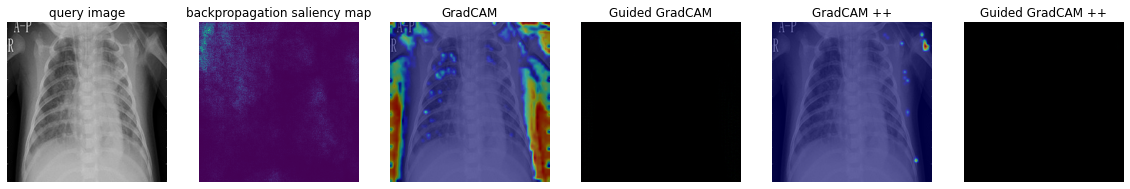

In [39]:
gradcamplus_saliency_map(model, query_image, -1, 'conv2d_1')

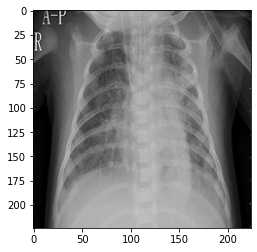

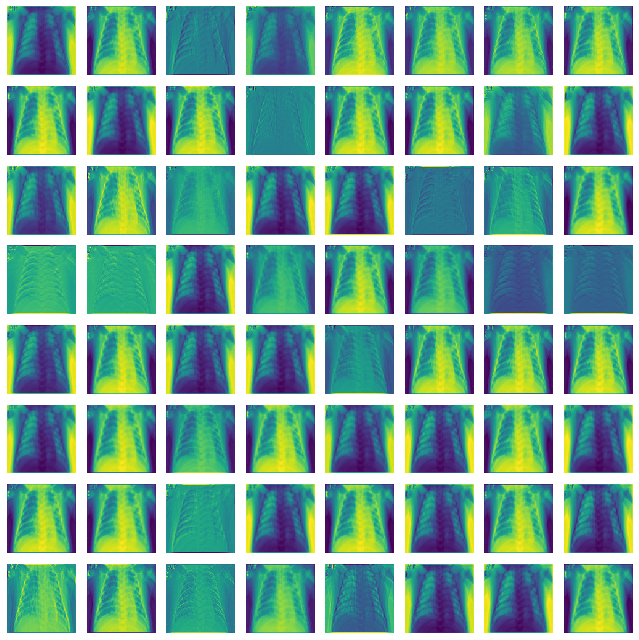

first_conv_layer_output


<Figure size 432x288 with 0 Axes>

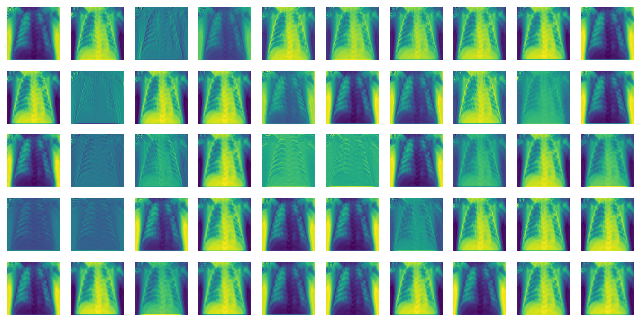

first_BN_layer_output


<Figure size 432x288 with 0 Axes>

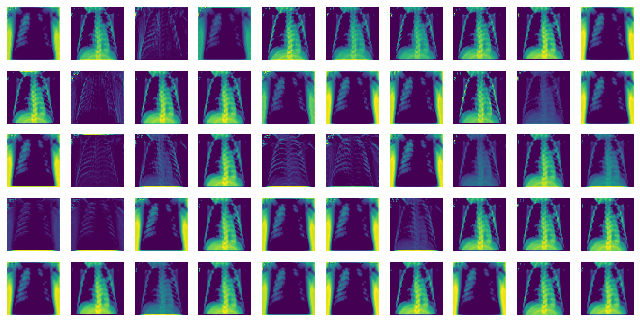

first_MP_layer_output


<Figure size 432x288 with 0 Axes>

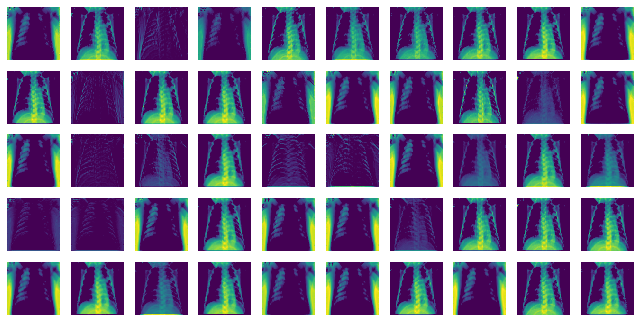

first_activation_layer_output


<Figure size 432x288 with 0 Axes>

In [40]:
image = load_img("/content/drive/MyDrive/Chest_XRay_Dataset02/check/Abnormal (Pneumonia))/person1946_bacteria_4874.jpg")
image = np.array(image)
plt.imshow(image)
plt.show()
query_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)

layer_name = 'conv2d'
intermediate_layer_model = Model(inputs= model.input,
                                 outputs= model.get_layer(layer_name).output)

# Query image intermediate output 
intermediate_output = intermediate_layer_model.predict(np.expand_dims(query_image,0))

intermediate_output.shape

def plot_output_at_various_layers(intermediate_output, layer_name, resized_img): 
    plt.figure(figsize=(9,9))
    for i in range(intermediate_output[0].shape[-1]):
        plt.subplot(8, 8, i+1)
        plt.imshow(intermediate_output[0][:,:,i], interpolation='nearest')
        plt.axis('off')      
    plt.tight_layout()
    plt.show()
    plt.savefig('first_conv_layer_output_final',dpi=400)
    print('first_conv_layer_output')
plot_output_at_various_layers(intermediate_output, layer_name, query_image)  

###########
layer_name = 'batch_normalization'
intermediate_layer_model = Model(inputs= model.input,
                                 outputs= model.get_layer(layer_name).output)

# Query image intermediate output 
intermediate_output = intermediate_layer_model.predict(np.expand_dims(query_image,0))

intermediate_output.shape

def plot_output_at_various_layers(intermediate_output, layer_name, resized_img):
    
    plt.figure(figsize=(9,9))
    for i in range(50):
        plt.subplot(10, 10, i+1)
        plt.imshow(intermediate_output[0][:,:,i], interpolation='nearest')
        plt.axis('off')      
    plt.tight_layout()
    plt.show()
    plt.savefig('BN_layer_output_final',dpi=400)
    print('first_BN_layer_output')
plot_output_at_various_layers(intermediate_output, layer_name, query_image)  

###########
layer_name = 'max_pooling2d'
intermediate_layer_model = Model(inputs= model.input,
                                 outputs= model.get_layer(layer_name).output)

# Query image intermediate output 
intermediate_output = intermediate_layer_model.predict(np.expand_dims(query_image,0))

intermediate_output.shape
def plot_output_at_various_layers(intermediate_output, layer_name, resized_img):
    
    plt.figure(figsize=(9,9))
    for i in range(50):
        plt.subplot(10, 10, i+1)
        plt.imshow(intermediate_output[0][:,:,i], interpolation='nearest')
        plt.axis('off')      
    plt.tight_layout()
    plt.show()
    plt.savefig('first_max_pooling_layer_output_final',dpi=400)
    print('first_MP_layer_output')
plot_output_at_various_layers(intermediate_output, layer_name, query_image)  

###########
layer_name = 'activation'
intermediate_layer_model = Model(inputs= model.input,
                                 outputs= model.get_layer(layer_name).output)

# Query image intermediate output 
intermediate_output = intermediate_layer_model.predict(np.expand_dims(query_image,0))

intermediate_output.shape
def plot_output_at_various_layers(intermediate_output, layer_name, resized_img):
    
    plt.figure(figsize=(9,9))
    for i in range(50):
        plt.subplot(10, 10, i+1)
        plt.imshow(intermediate_output[0][:,:,i], interpolation='nearest')
        plt.axis('off')      
    plt.tight_layout()
    plt.show()
    plt.savefig('first_activation_layer_output_final',dpi=400)
    print('first_activation_layer_output')
plot_output_at_various_layers(intermediate_output, layer_name, query_image)  

Shape of each image : (224, 224, 3)


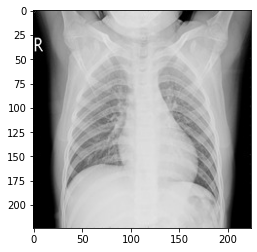

resized_img Dimensions :  (224, 224, 3)


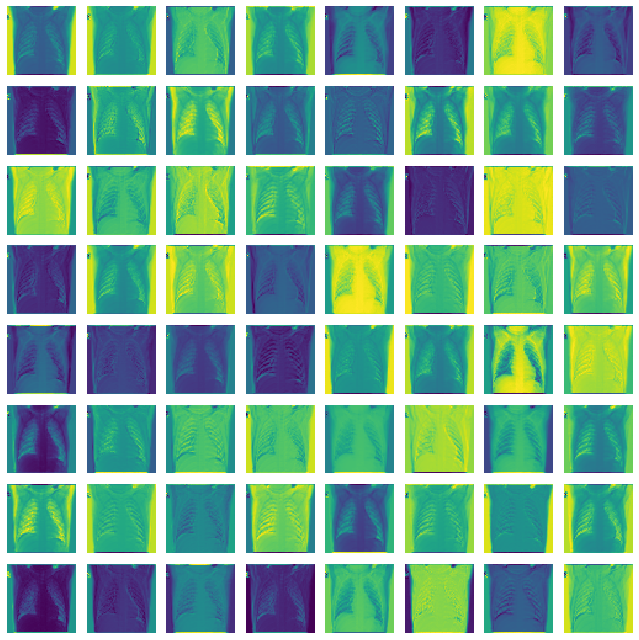

second_conv_layer_output


<Figure size 432x288 with 0 Axes>

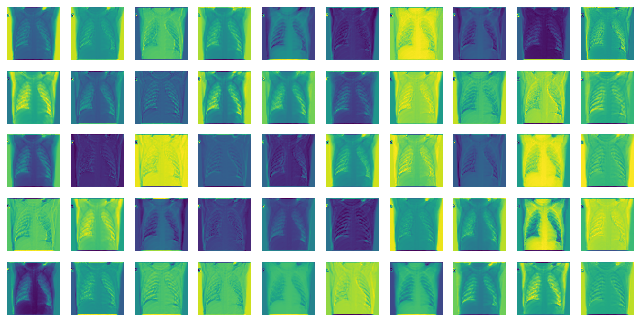

second_BN_layer_output


<Figure size 432x288 with 0 Axes>

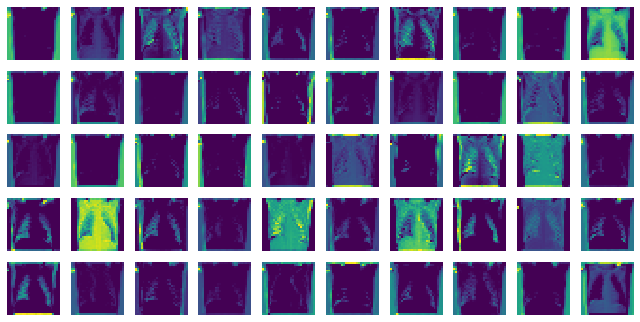

second_MP_layer_output


<Figure size 432x288 with 0 Axes>

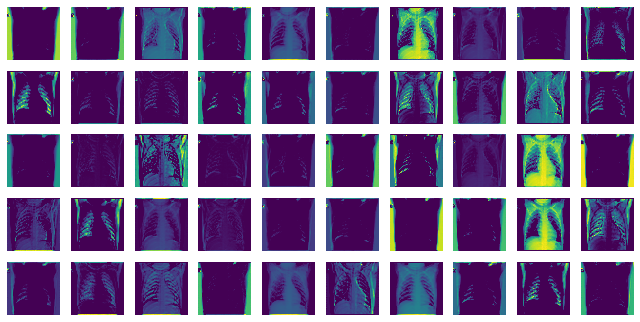

second_Activation_layer_output


<Figure size 432x288 with 0 Axes>

In [41]:
image = load_img("/content/drive/MyDrive/Chest_XRay_Dataset02/check/Normal/NORMAL2-IM-1427-0001.jpg")
image = np.array(image)
print(f"Shape of each image : {image.shape}")
plt.imshow(image)
plt.show()

query_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
print('resized_img Dimensions : ',query_image.shape)

#######

layer_name = 'conv2d_1'
intermediate_layer_model = Model(inputs= model.input,
                                 outputs= model.get_layer(layer_name).output)

# Query image intermediate output 
intermediate_output = intermediate_layer_model.predict(np.expand_dims(query_image,0))

intermediate_output.shape

def plot_output_at_various_layers(intermediate_output, layer_name, resized_img): 
    plt.figure(figsize=(9,9))
    for i in range(intermediate_output[0].shape[-1]):
        plt.subplot(8, 8, i+1)
        plt.imshow(intermediate_output[0][:,:,i], interpolation='nearest')
        plt.axis('off')      
    plt.tight_layout()
    plt.show()
    plt.savefig('first_conv_layer_output_final',dpi=400)
    print('second_conv_layer_output')
plot_output_at_various_layers(intermediate_output, layer_name, query_image)  

###########
layer_name = 'batch_normalization_1'
intermediate_layer_model = Model(inputs= model.input,
                                 outputs= model.get_layer(layer_name).output)

# Query image intermediate output 
intermediate_output = intermediate_layer_model.predict(np.expand_dims(query_image,0))

intermediate_output.shape

def plot_output_at_various_layers(intermediate_output, layer_name, resized_img):
    
    plt.figure(figsize=(9,9))
    for i in range(50):
        plt.subplot(10, 10, i+1)
        plt.imshow(intermediate_output[0][:,:,i], interpolation='nearest')
        plt.axis('off')      
    plt.tight_layout()
    plt.show()
    plt.savefig('BN_layer_output_final',dpi=400)
    print('second_BN_layer_output')
plot_output_at_various_layers(intermediate_output, layer_name, query_image)  

###########
layer_name = 'max_pooling2d_1'
intermediate_layer_model = Model(inputs= model.input,
                                 outputs= model.get_layer(layer_name).output)

# Query image intermediate output 
intermediate_output = intermediate_layer_model.predict(np.expand_dims(query_image,0))

intermediate_output.shape
def plot_output_at_various_layers(intermediate_output, layer_name, resized_img):
    
    plt.figure(figsize=(9,9))
    for i in range(50):
        plt.subplot(10, 10, i+1)
        plt.imshow(intermediate_output[0][:,:,i], interpolation='nearest')
        plt.axis('off')      
    plt.tight_layout()
    plt.show()
    plt.savefig('first_max_pooling_layer_output_final',dpi=400)
    print('second_MP_layer_output')
plot_output_at_various_layers(intermediate_output, layer_name, query_image)  


###########
layer_name = 'activation_1'
intermediate_layer_model = Model(inputs= model.input,
                                 outputs= model.get_layer(layer_name).output)

# Query image intermediate output 
intermediate_output = intermediate_layer_model.predict(np.expand_dims(query_image,0))

intermediate_output.shape
def plot_output_at_various_layers(intermediate_output, layer_name, resized_img):
    
    plt.figure(figsize=(9,9))
    for i in range(50):
        plt.subplot(10, 10, i+1)
        plt.imshow(intermediate_output[0][:,:,i], interpolation='nearest')
        plt.axis('off')      
    plt.tight_layout()
    plt.show()
    plt.savefig('first_activation_layer_output_final',dpi=400)
    print('second_Activation_layer_output')
plot_output_at_various_layers(intermediate_output, layer_name, query_image)  

In [42]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1255
           1       0.92      0.93      0.93       497

    accuracy                           0.96      1752
   macro avg       0.95      0.95      0.95      1752
weighted avg       0.96      0.96      0.96      1752



In [43]:
cm = confusion_matrix(y_test_new, pred)

Confusion matrix, without normalization


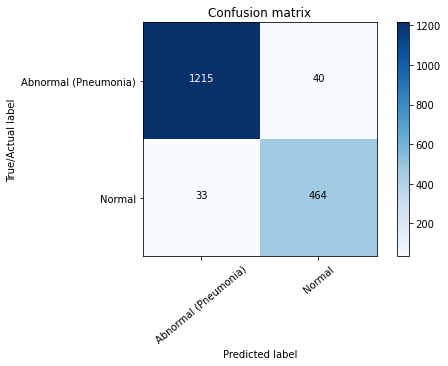

In [44]:
import itertools
from itertools import product
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.figure(figsize=(7,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True/Actual label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm,labels)
plt.savefig('CXRay_SPNetCM',dpi=400)

In [47]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]

In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score

print('Accuracy: %.5f' % accuracy_score(y_test_new, pred), 'Precision: %.5f' % precision_score(y_test_new, pred),' Recall: %.5f' % recall_score(y_test_new, pred), 
      'F1 Score: %.5f' % f1_score(y_test_new, pred), 'AUC Score: %.5f' % roc_auc_score(y_test_new, pred))

Accuracy: 0.95833 Precision: 0.92063  Recall: 0.93360 F1 Score: 0.92707 AUC Score: 0.95086


In [49]:
specificity=TN/float(TN+FP)
print(specificity)
print(roc_auc_score(y_test_new, pred))
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test_new, pred)

0.9681274900398407
0.9508645498488941


0.041666666666666664

In [50]:
acc = accuracy_score(y_test_new, pred)*100
auc=roc_auc_score(y_test_new, pred)*100
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
specificity = tn/(tn+fp)*100
print('Accuracy: {0:0.3f}%'.format(acc))
print('Precision: {0:0.3f}%'.format(precision))
print('Recall or Sensitivity: {0:0.3f}%'.format(recall))
print('Specificity: {0:0.3f}%'.format(specificity))
print('F1-score: {0:0.3f}%'.format(2*precision*recall/(precision+recall)))
print('AUC-score: {0:0.3f}%'.format(auc))
print('Train acc: {0:0.3f}%'.format(np.round((history.history['accuracy'][-1])*100, 2)))
print('Validation acc: {0:0.3f}%'.format(np.round((history.history['val_accuracy'][-1])*100, 2)))

Accuracy: 95.833%
Precision: 92.063%
Recall or Sensitivity: 93.360%
Specificity: 96.813%
F1-score: 92.707%
AUC-score: 95.086%
Train acc: 100.000%
Validation acc: 95.970%
